In [42]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import NamedTuple
import math
from enum import Enum, auto
import re
from matplotlib.ticker import PercentFormatter

In [43]:
class Actor(Enum):
    GAITNET = "gaitnet"
    CONTACTNET = "contactnet"

In [44]:
file_name_regex = re.compile(r'([a-zA-Z]+)_eval_d(\d+(?:\.\d+)?)_v(\d+(?:\.\d+)?)\.csv')
"""match groups:
 - 1: network (gaitnet or contactnet)
 - 2: terrain difficulty (float)
 - 3: command velocity (float)
"""

class DataPoint(NamedTuple):
    network: Actor
    terrain_difficulty: float
    command_velocity: float
    distances: np.ndarray
    success: np.ndarray

    @staticmethod
    def from_csv(file_path: Path) -> "DataPoint":
        df = pd.read_csv(file_path)

        match = file_name_regex.match(file_path.name)
        if match is None:
            raise ValueError(f"Filename {file_path.name} does not match expected pattern")

        network_str, terrain_difficulty, command_velocity = match.groups()
        network = Actor(network_str)
        terrain_difficulty = float(terrain_difficulty)
        command_velocity = float(command_velocity)

        distances = df['distance'].to_numpy()
        success = df['truncated'].to_numpy().astype(bool)
        
        return DataPoint(
            network=network,
            terrain_difficulty=terrain_difficulty,
            command_velocity=command_velocity,
            distances=distances,
            success=success
        )

In [45]:
data_folder = Path.cwd() / "data"
data_files = list(data_folder.glob("*.csv"))
data_points = [DataPoint.from_csv(fp) for fp in data_files]
data_points

[DataPoint(network=<Actor.GAITNET: 'gaitnet'>, terrain_difficulty=0.1, command_velocity=0.05, distances=array([0.69704837, 0.68903464, 0.7000798 , 0.71426183, 0.744163  ,
        0.6700289 , 0.7104956 , 0.7657459 , 0.7076102 , 0.6691158 ,
        0.8713738 , 0.70433927, 0.6701328 , 0.72682273, 0.7190994 ,
        0.72418547, 0.7377583 , 0.7711337 , 0.6908337 , 0.76069015,
        0.7047259 , 0.71471727, 0.69313836, 0.69540894, 0.72920257,
        0.7201073 , 0.76915354, 0.72522116, 0.7189082 , 0.7127496 ,
        0.72836435, 0.705412  , 0.7379209 , 0.7185591 , 0.77304065,
        0.70520115, 0.7226632 , 0.7135191 , 0.72345436, 0.68991846,
        0.72992504, 0.7449574 , 0.68522024, 0.70415825, 0.702157  ,
        0.7298694 , 0.72459936, 0.69139695, 0.7187699 , 0.7576897 ]), success=array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  T

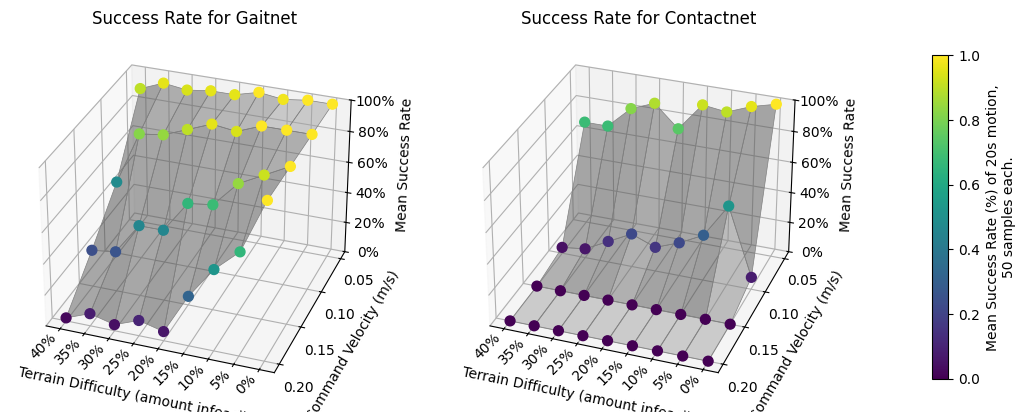

In [61]:
# plot a 3d surface plot of terrain difficulty (x), command velocity (y), and mean success rate (z)
# one plot for each network

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Store scatter plot for colorbar
sc = None

for count, (network, ax) in enumerate(zip(Actor, [ax1, ax2])):
    network_data = [dp for dp in data_points if dp.network == network]
    
    # Get unique terrain difficulties and command velocities
    unique_difficulties = sorted(set(dp.terrain_difficulty for dp in network_data))
    unique_velocities = sorted(set(dp.command_velocity for dp in network_data))
    
    # Create a grid for the surface
    X, Y = np.meshgrid(unique_difficulties, unique_velocities)
    Z = np.zeros_like(X)
    
    # Fill in the Z values from our data
    for dp in network_data:
        i = unique_velocities.index(dp.command_velocity)
        j = unique_difficulties.index(dp.terrain_difficulty)
        Z[i, j] = np.mean(dp.success)
    
    # Plot surface with no interpolation in neutral gray color
    surf = ax.plot_surface(X, Y, Z, color='lightgray', edgecolor='gray', linewidth=0.5, alpha=0.5)
    
    # Plot the actual data points with color mapping
    xs = np.array([dp.terrain_difficulty for dp in network_data])
    ys = np.array([dp.command_velocity for dp in network_data])
    zs = np.array([np.mean(dp.success) for dp in network_data])
    sc = ax.scatter(xs, ys, zs, c=zs, cmap='viridis', s=50, depthshade=False, zorder=5, vmin=0, vmax=1)

    ax.set_title(f'Success Rate for {network.value.capitalize()}')
    ax.set_xlabel('Terrain Difficulty (amount infeasible)')
    ax.set_ylabel('Command Velocity (m/s)')
    ax.set_zlabel('Mean Success Rate')
    ax.set_zlim(0, 1)

    # Format axes as percentages (assumes values in [0, 1])
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.zaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    
    # Set ticks to only show where data points exist
    ax.set_xticks(unique_difficulties)
    ax.set_yticks(unique_velocities)
    
    # Rotate x-axis tick labels and adjust padding
    ax.xaxis.labelpad = 3
    ax.yaxis.labelpad = 5
    ax.zaxis.labelpad = 7
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_rotation(45)
        tick.label1.set_horizontalalignment('right')
        tick.set_pad(-7)
    
    # Rotate view -90 degrees about z-axis (adjust azimuth)
    ax.view_init(elev=30, azim=110)

# Add a single colorbar for both plots
fig.colorbar(sc, ax=[ax1, ax2], shrink=0.7, pad=0.1, label='Mean Success Rate (%) of 20s motion,\n50 samples each.')

plt.savefig('plot.png', dpi=300, bbox_inches='tight', pad_inches=0.3)